Dataset '/content/dataset.csv' loaded successfully.

First 5 rows of the dataset:
    signal_name      fan_in    num_gates    path_length    logic_depth
 0  P_3_3                 6           36              8             12
 1  P_3_0                 1           10              7              7
 2  P_0_2                 4           32              3              9
 3  P_2_0                 3           15              8              9
 4  P_2_3                 1            4              4              4

Dataset Statistics:
         fan_in    num_gates    path_length    logic_depth
count  500           500          500            500
mean     3.438        24.162        4.964          8.438
std      1.6923       13.789        2.02358        2.20724
min      1             4            2              3
25%      2            12            3              7
50%      3            24            5              8.5
75%      5            32            7             10
max      6            60     

<ipython-input-3-ca2808333ada>:107: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  y_pred_encoded = y_pred_binned.map(label_mapping)


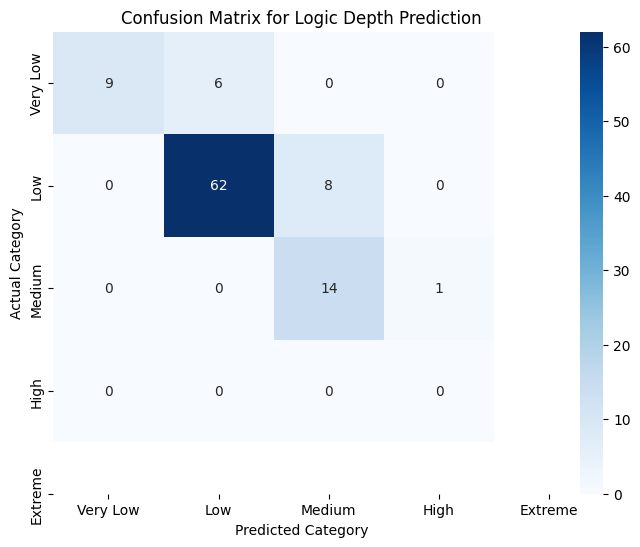

In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    median_absolute_error, explained_variance_score, max_error,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# File paths
dataset_path = "/content/dataset.csv"
predicted_path = "/content/predicted_logic_depth.csv"

# Step 1: Load Dataset
df = pd.read_csv(dataset_path)
print(f"Dataset '{dataset_path}' loaded successfully.\n")
print("First 5 rows of the dataset:")
print(tabulate(df.head(), headers="keys", tablefmt="plain"))
print("\nDataset Statistics:")
print(tabulate(df.describe(), headers="keys", tablefmt="plain"))

# Step 2: Select Features & Target
X = df[['fan_in', 'num_gates', 'path_length']]
y = df['logic_depth']

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train XGBoost Model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb_model.fit(X_train, y_train)

# Step 5: Predict and Validate
y_pred = xgb_model.predict(X_test)

# Step 6: Compute Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
med_ae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
max_err = max_error(y_test, y_pred)

# Print Results
print("\nModel Evaluation Metrics:")
eval_metrics = [
    ["Mean Squared Error (MSE)", mse],
    ["Mean Absolute Error (MAE)", mae],
    ["Root Mean Squared Error (RMSE)", rmse],
    ["Mean Absolute Percentage Error (MAPE)", f"{mape}%"],
    ["Median Absolute Error (MedAE)", med_ae],
    ["R² Score", r2],
    ["Explained Variance Score (EVS)", evs],
    ["Max Error", max_err]
]
print(tabulate(eval_metrics, headers=["Metric", "Value"], tablefmt="plain"))

# Step 7: Perform Cross-Validation
cv_scores = cross_val_score(xgb_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

print("\nCross-Validation Results:")
cv_results = [
    ["Fold 1", -cv_scores[0]],
    ["Fold 2", -cv_scores[1]],
    ["Fold 3", -cv_scores[2]],
    ["Fold 4", -cv_scores[3]],
    ["Fold 5", -cv_scores[4]],
    ["Average MSE", -np.mean(cv_scores)]
]
print(tabulate(cv_results, headers=["Cross-Validation", "MSE Score"], tablefmt="plain"))

# Step 8: Predict Logic Depth for Full Dataset
df['predicted_logic_depth'] = xgb_model.predict(X_scaled)

# Step 9: Save Predictions
df.to_csv(predicted_path, index=False)
print(f"\nPredicted logic depth saved as '{predicted_path}'")

# Step 10: Convert Continuous Predictions to Categories for Classification Metrics
bins = [0, 5, 10, 15, 20, np.inf]  # Define bin ranges
labels = ['Very Low', 'Low', 'Medium', 'High', 'Extreme']

y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

# Convert categories to integer labels
label_mapping = {label: idx for idx, label in enumerate(labels)}
y_test_encoded = y_test_binned.map(label_mapping)
y_pred_encoded = y_pred_binned.map(label_mapping)

# Step 11: Compute Classification Metrics
accuracy = accuracy_score(y_test_encoded, y_pred_encoded) * 100
precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0) * 100
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0) * 100
f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0) * 100

print("\nClassification Metrics:")
classification_metrics = [
    ["Accuracy", f"{accuracy:.2f}%"],
    ["Precision", f"{precision:.2f}%"],
    ["Recall", f"{recall:.2f}%"],
    ["F1 Score", f"{f1:.2f}%"]
]
print(tabulate(classification_metrics, headers=["Metric", "Value"], tablefmt="plain"))

# Step 12: Generate Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Logic Depth Prediction")
plt.show()


In [ ]:
import pandas as pd

# Load the predicted logic depth CSV file for Wallace Tree Multiplier
predicted_path = "/content/predicted_wallace_tree.csv"

try:
    df = pd.read_csv(predicted_path)
    print("🔹 Predicted Combinational Depth of the Wallace Tree Multiplier")
    print(df.head())  # Show the first few rows
except FileNotFoundError:
    print(f"Error: Predicted logic depth file '{predicted_path}' not found.")


🔹 Predicted Combinational Depth of the Wallace Tree Multiplier
      A     B         P  fan_in  num_gates  path_length  logic_depth
0  1001     0         0       3         22            9     5.912453
1  1010    10     10100       3         22            7     4.347573
2     1  1010      1010       3         18            8     4.692709
3  1010  1111  10010110       3         28            4     4.848717
4     1  1011      1011       3         27            9     4.602222
